In [1]:
import glob,os
import numpy as np
import pandas as pd


import matplotlib.pylab as plt
%matplotlib inline

from scipy.spatial.distance import pdist,squareform

import cooler
import gzip
from io import StringIO

## Functions

In [2]:
def generate_sampled_matrix(probability_map, total_reads):
    # 确保输入是对称矩阵
    assert np.allclose(probability_map, probability_map.T), "Input matrix must be symmetric"
    
    # 获取矩阵的上三角部分（包括对角线），并将其展平
    upper_triangle_indices = np.triu_indices_from(probability_map)
    upper_triangle_probs = probability_map[upper_triangle_indices]
    
    # 根据上三角部分的概率进行采样
    sampled_indices_flat = np.random.choice(a=upper_triangle_probs.size, size=total_reads, p=upper_triangle_probs / upper_triangle_probs.sum())
    sampled_2d_indices = (upper_triangle_indices[0][sampled_indices_flat], upper_triangle_indices[1][sampled_indices_flat])
    
    # 初始化结果矩阵，并根据采样结果更新上三角矩阵
    sampled_counts_matrix = np.zeros_like(probability_map)
    np.add.at(sampled_counts_matrix, sampled_2d_indices, 1)
    
    # 将上三角矩阵复制到下三角，保持矩阵对称
    sampled_counts_matrix = sampled_counts_matrix + np.triu(sampled_counts_matrix, 1).T
    
    return sampled_counts_matrix

def plot_matrix(mat,title,cmap,vmax,show):
    plt.figure(figsize=(4,4))
    plt.imshow(mat,interpolation='nearest',cmap=cmap,vmax=vmax)
    if show:
        plt.colorbar()
    plt.title(title)
    #不显示刻度
    plt.xticks([])
    plt.yticks([])
    plt.show()

# def generate_probability_matrix(distance_matrix):
#     # Calculate the inverse distance matrix, setting diagonal to zero to avoid division by zero
#     with np.errstate(divide='ignore', invalid='ignore'):
#         inverse_distance_matrix = np.nan_to_num(1 / distance_matrix)
#         np.fill_diagonal(inverse_distance_matrix, 0)

#     # Scale the inverse distance matrix to create a probability map
#     probability_map = inverse_distance_matrix / inverse_distance_matrix.sum()
#     return probability_map

def generate_probability_matrix(distance_matrix, min_distance=1e-5):
    # Avoid division by very small values by setting a minimum distance
    distance_matrix_clipped = np.maximum(distance_matrix, min_distance)
    
    # Calculate the inverse distance matrix, setting diagonal to zero to avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        inverse_distance_matrix = np.nan_to_num(1 / distance_matrix_clipped)
        np.fill_diagonal(inverse_distance_matrix, 0)

    # Scale the inverse distance matrix to create a probability map
    probability_map = inverse_distance_matrix / inverse_distance_matrix.sum()
    return probability_map



def get_start_position(coord):
    return int(coord.split(':')[1].split('-')[0])

def is_symmetric(matrix):
    n = len(matrix)  # 矩阵的大小（行数和列数）
    for i in range(n):
        for j in range(i, n):  # 只检查矩阵的上三角部分
            if np.isnan(matrix[i,j]) and np.isnan(matrix[j,i]):
                continue  # 如果两个位置都是 None，认为它们相等
            if matrix[i][j] != matrix[j][i]:
                return False
    return True

## Read Files

Science

In [3]:
# Dataset1
# file_ = "/shareb/mliu/evaluate_impute/data/image_data/Science2018/HCT116_chr21-34-37Mb_6h auxin.csv"
file_ = "/shareb/mliu/evaluate_impute/data/image_data/Science2018/HCT116_chr21-34-37Mb_untreated.csv"
with open(file_, 'r') as file:
    lines = [line.strip().split(',') for line in file]
keep = np.array(list(map(len, lines))) > 1

data = np.array([line for line,kp in zip(lines,keep) if kp][1:],dtype=float)
chromosomes = data[:,0]
nchr = len(np.unique(chromosomes))
zxys_science = data[:,2:].reshape([nchr,-1,3])
print (zxys_science.shape)


(11631, 83, 3)


Cell

In [9]:
#Dataset2
df_cell = pd.read_csv("/shareb/mliu/evaluate_impute/image_analysis/data/chromosome2.tsv",sep="\t")
df_cell['Start_Position'] = df_cell['Genomic coordinate'].apply(get_start_position)
df_cell['pos'] = df_cell['Start_Position'] + 25000
df_cell_cell_list = df_cell['Chromosome copy number'].unique().tolist()
df_cell

,Z(nm),X(nm),Y(nm),Genomic coordinate,Chromosome copy number,Start_Position,pos
0,2563.0,28158.0,6018.0,chr2:1-50001,1,1,25001
1,2781.0,27867.0,6245.0,chr2:250001-300001,1,250001,275001
2,2141.0,27882.0,6015.0,chr2:500001-550001,1,500001,525001
3,3071.0,28238.0,5163.0,chr2:750001-800001,1,750001,775001
4,2896.0,28429.0,5077.0,chr2:1000001-1050001,1,1000001,1025001
...,...,...,...,...,...,...,...
2832110,4213.0,19213.0,15247.0,chr2:241000001-241050001,3029,241000001,241025001
2832111,4362.0,18724.0,15322.0,chr2:241250001-241300001,3029,241250001,241275001
2832112,4041.0,18990.0,15424.0,chr2:241500001-241550001,3029,241500001,241525001
2832113,4057.0,19367.0,15126.0,chr2:241750001-241800001,3029,241750001,241775001


In [13]:
# save df_cell.query("`Chromosome copy number`==1")['pos'] to txt
df_cell.query("`Chromosome copy number`==1")['pos'].to_csv("pos1.txt",index=False,header=False,sep="\t")


In [8]:
grouped_by_chromosome = df_cell.groupby('Chromosome copy number')

# Initialize an empty list to hold the arrays
chromosome_arrays = []

# Iterate through the groups and extract coordinates
for _, group in grouped_by_chromosome:
    coordinates = group[['Z(nm)', 'X(nm)', 'Y(nm)']].values
    chromosome_arrays.append(coordinates)
    
zxys_cell = np.stack(chromosome_arrays, axis=0)

print(zxys_cell.shape)

(3029, 935, 3)


In [4]:
df_cell['Start_Position_bin'] = df_cell['Start_Position']//1000000
df_cell_1Mb_bin = pd.DataFrame(columns=['Chromosome copy number','Start_Position_bin'])
Start_Position_bin_list = list(np.arange(0,243))
df_cell_1Mb_bin['Chromosome copy number'] = [i for i in df_cell_cell_list for j in range(243)]
df_cell_1Mb_bin['Start_Position_bin'] = Start_Position_bin_list * len(df_cell_cell_list)

In [6]:
#df_cell按照Chromosome copy number和Start_Position_bin进行group,取Z(nm)	X(nm)	Y(nm)的平均
df_cell_1Mb = df_cell.groupby(['Chromosome copy number', 'Start_Position_bin']).agg({'Z(nm)': 'mean', 'X(nm)': 'mean', 'Y(nm)': 'mean'})
df_cell_1Mb.reset_index(inplace=True)

In [8]:
df_merged = pd.merge(df_cell_1Mb_bin, df_cell_1Mb, on=['Chromosome copy number','Start_Position_bin'], how='left')

# 对于df_cell_1Mb中缺少的Start_Position_bin值，将Z(nm), X(nm), Y(nm)设置为NaN
df_merged['Z(nm)'].fillna(np.nan, inplace=True)
df_merged['X(nm)'].fillna(np.nan, inplace=True)
df_merged['Y(nm)'].fillna(np.nan, inplace=True)

In [16]:
grouped_by_chromosome = df_merged.groupby('Chromosome copy number')

# Initialize an empty list to hold the arrays
chromosome_arrays = []

# Iterate through the groups and extract coordinates
for _, group in grouped_by_chromosome:
    coordinates = group[['Z(nm)', 'X(nm)', 'Y(nm)']].values
    chromosome_arrays.append(coordinates)
    
zxys_cell = np.stack(chromosome_arrays, axis=0)

print(zxys_cell.shape)

(3029, 243, 3)


## Compute distance

Science

In [36]:
#Science 2018
distance_mats_science = np.array([squareform(pdist(zxy)) for zxy in zxys_science])
distance_mats_science[distance_mats_science==0] = np.nan
for i, mat in enumerate(distance_mats_science):
    # 忽略NaN值计算IQR
    q1 = np.nanpercentile(mat, 0.05)
    distance_mats_science[i][mat < q1] = np.nan


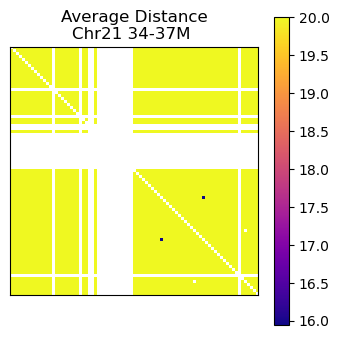

In [39]:
cmap = "plasma"
vmax = 20
plot_matrix(distance_mats_science[3436],f"Average Distance\nChr21 34-37M ",cmap,vmax,show=True)

Cell

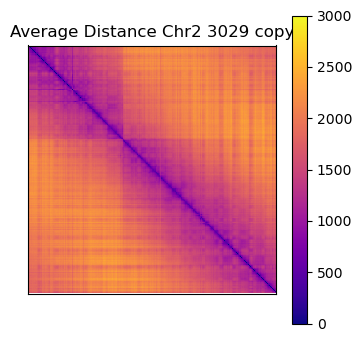

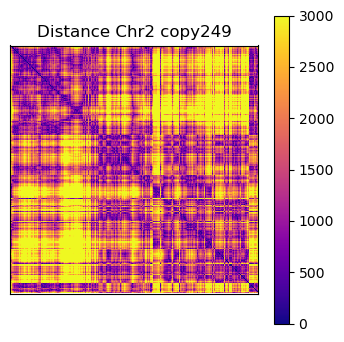

In [14]:
#Cell 2020
distance_mats_cell = np.array([squareform(pdist(zxy)) for zxy in zxys_cell])
med_mat_cell = np.nanmedian(distance_mats_cell,axis=0)
cmap = "plasma"
vmax = 3000
plot_matrix(med_mat_cell,f"Average Distance Chr2 3029 copy",cmap,vmax,True)

i = 249
plot_matrix(distance_mats_cell[i],f"Distance Chr2 copy{i}",cmap,vmax,True)


## Ground Truth (Probability Matrix)

In [42]:
#Science
probability_list_science = []
for i in range(distance_mats_science.shape[0]):
    distance_matrix = distance_mats_science[i]
    probability_matrix = generate_probability_matrix(distance_matrix)
    probability_list_science.append(probability_matrix)
#probability_list to array
probability_mattrix_array_science = np.array(probability_list_science)
print(probability_mattrix_array_science.shape)


save_dir_prob = "/shareb/mliu/evaluate_impute/data/simulation_hic/Science2018/prob"
filename = "Science2018_prob_matrix.npy"
np.save(os.path.join(save_dir_prob,filename),probability_mattrix_array_science)

(11631, 83, 83)


In [157]:

save_dir_prob = "/shareb/mliu/evaluate_impute/data/simulation_hic/Science2018/prob"
filename = "Science2018_prob_matrix.npy"
probability_mattrix_array_science = np.load(os.path.join(save_dir_prob,filename))



In [12]:
prob_mat_science = np.nanmean(probability_mattrix_array_science,axis=0)
prob_mat_science_sum = np.nansum(probability_mattrix_array_science,axis=0)

In [159]:
distance_matrix=distance_mats_science[8917]
min_distance=1e-5
# Avoid division by very small values by setting a minimum distance
distance_matrix_clipped = np.maximum(distance_matrix, min_distance)

# Calculate the inverse distance matrix, setting diagonal to zero to avoid division by zero
with np.errstate(divide='ignore', invalid='ignore'):
    inverse_distance_matrix = np.nan_to_num(1 / distance_matrix_clipped)
    np.fill_diagonal(inverse_distance_matrix, 0)

# Scale the inverse distance matrix to create a probability map
probability_map = inverse_distance_matrix / inverse_distance_matrix.sum()

In [162]:
np.nanmin(distance_matrix_clipped)
np.nanmax(probability_mattrix_array_science[8917])

0.03415768788424532

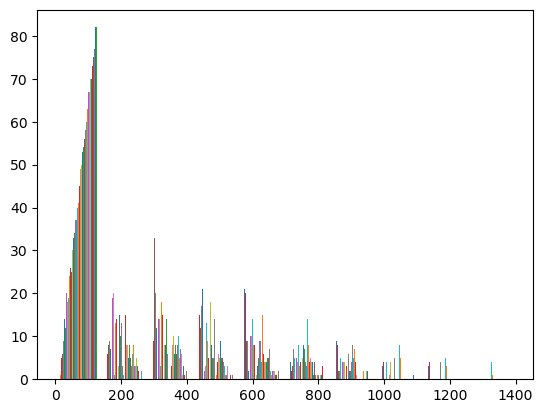

In [149]:
list1 = np.triu(distance_matrix).tolist()
plt.hist(list1)
plt.show()

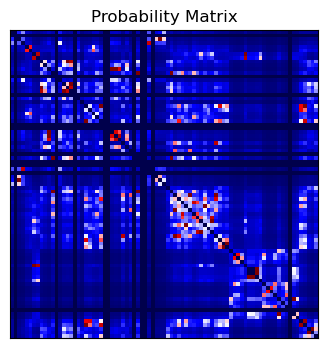

In [184]:
plot_matrix(probability_mattrix_array_science[8917],f"Probability Matrix",cmap="seismic",vmax=0.001,show=False)
# plot_matrix(prob_mat_science,f"Average 11631 copies Probability Matrix\n Chr21 34-37M ",cmap="seismic",vmax=0.00025,show=False)

# plot_matrix(prob_mat_science_sum,f"Probability Matrix",cmap="seismic",vmax=2.4,show=False)

cell

In [15]:
#Cell
probability_list_cell = []
for i in range(distance_mats_cell.shape[0]):
    probability_matrix = generate_probability_matrix(distance_mats_cell[i])
    probability_list_cell.append(probability_matrix)


In [16]:
#probability_list to array
probability_mattrix_array_cell = np.array(probability_list_cell)
print(probability_mattrix_array_cell.shape)

save_dir_prob = "/shareb/mliu/evaluate_impute/data/simulation_hic/Cell2020/prob"
filename = "Cell2020_prob_matrix_250kb.npy"
np.save(os.path.join(save_dir_prob,filename),probability_mattrix_array_cell)

(3029, 935, 935)


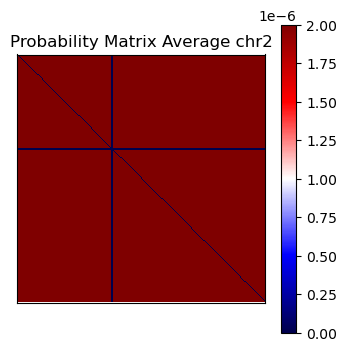

In [21]:
prob_mat_cell = np.nanmedian(probability_mattrix_array_cell,axis=0) #慢



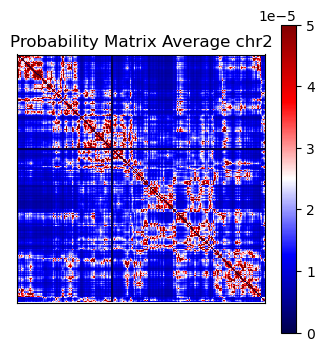

In [28]:
i = 5
cmap = "seismic"
vmax = 0.00005
plot_matrix(probability_mattrix_array_cell[i],f"Probability Matrix Average chr2",cmap,vmax,True)

## DownSample to single cell

Science 2018

In [3]:
probability_mattrix_array_science = np.load("/shareb/mliu/evaluate_impute/data/simulation_hic/Science2018/prob/Science2018_prob_matrix.npy")
print(probability_mattrix_array_science.shape)

(11631, 83, 83)


In [195]:
sample_list1_science = []
for i in range(probability_mattrix_array_science.shape[0]):
    reads = np.random.randint(100,250)
    sample_list1_science.append(generate_sampled_matrix(probability_mattrix_array_science[i],total_reads=reads))
sample_mattrix_array1_science = np.array(sample_list1_science)


sample_list2_science = []
for i in range(probability_mattrix_array_science.shape[0]):
    reads = np.random.randint(250,500)
    probability_matrix = generate_sampled_matrix(probability_mattrix_array_science[i],total_reads=reads)
    sample_list2_science.append(probability_matrix)
sample_mattrix_array2_science  = np.array(sample_list2_science)


sample_list3_science = []
for i in range(probability_mattrix_array_science.shape[0]):
    reads = np.random.randint(500,1000)
    probability_matrix = generate_sampled_matrix(probability_mattrix_array_science[i],total_reads=reads)
    sample_list3_science.append(probability_matrix)
#probability_list to array
sample_mattrix_array3_science  = np.array(sample_list3_science)


sample_list4_science = []
for i in range(probability_mattrix_array_science.shape[0]):
    reads = np.random.randint(1000,2500)
    probability_matrix = generate_sampled_matrix(probability_mattrix_array_science[i],total_reads=reads)
    sample_list4_science.append(probability_matrix)
sample_mattrix_array4_science  = np.array(sample_list4_science)


save_dir_hic = "/shareb/mliu/evaluate_impute/data/simulation_hic/Science2018/hic/matrix"
filename = "Science2018_sample_matrix1.npy"
np.save(os.path.join(save_dir_hic,filename),sample_mattrix_array1_science)

filename = "Science2018_sample_matrix2.npy"
np.save(os.path.join(save_dir_hic,filename),sample_mattrix_array2_science)


filename = "Science2018_sample_matrix3.npy"
np.save(os.path.join(save_dir_hic,filename),sample_mattrix_array3_science)


filename = "Science2018_sample_matrix4.npy"
np.save(os.path.join(save_dir_hic,filename),sample_mattrix_array4_science)


In [12]:
mean_sample_mat1_science = np.nanmean(sample_mattrix_array1_science,axis=0)
mean_sample_mat2_science = np.nanmean(sample_mattrix_array2_science,axis=0)
mean_sample_mat3_science = np.nanmean(sample_mattrix_array3_science,axis=0)
mean_sample_mat4_science = np.nanmean(sample_mattrix_array4_science,axis=0)
cmap = "seismic"
plot_matrix(mean_sample_mat1_science,f"Sampled Matrix1 Average chr21",cmap,vmax=0.5,show=False)
plot_matrix(mean_sample_mat2_science,f"Sampled Matrix2 Average chr21",cmap,vmax=0.7,show=False)
plot_matrix(mean_sample_mat3_science,f"Sampled Matrix3 Average chr21",cmap,vmax=0.9,show=False)
plot_matrix(mean_sample_mat4_science,f"Sampled Matrix4 Average chr21",cmap,vmax=1.3,show=False)

Cell 2020

In [3]:
save_dir_hic = "/shareb/mliu/evaluate_impute/data/simulation_hic/Cell2020/hic/matrix"

In [4]:
save_dir_prob = "/shareb/mliu/evaluate_impute/data/simulation_hic/Cell2020/prob"
filename = "Cell2020_prob_matrix_250kb.npy"
probability_mattrix_array_cell = np.load(os.path.join(save_dir_prob,filename))
#这里还是对称的呢

In [5]:
sample_list1_cell = []
for i in range(probability_mattrix_array_cell.shape[0]):
    reads = np.random.randint(250,500)
    probability_matrix = generate_sampled_matrix(probability_mattrix_array_cell[i],total_reads=reads)
    sample_list1_cell.append(probability_matrix)
sample_mattrix_array1_cell = np.array(sample_list1_cell)
print(sample_mattrix_array1_cell.shape)
filename = "Cell2020_sample_matrix1_250kb.npy"
np.save(os.path.join(save_dir_hic,filename),sample_mattrix_array1_cell)
# del sample_mattrix_array1_cell

(3029, 935, 935)


In [5]:

sample_list2_cell  = []
for i in range(probability_mattrix_array_cell.shape[0]):
    reads = np.random.randint(500,1000)
    probability_matrix = generate_sampled_matrix(probability_mattrix_array_cell[i],total_reads=reads)
    sample_list2_cell.append(probability_matrix)
sample_mattrix_array2_cell = np.array(sample_list2_cell)
filename = "Cell2020_sample_matrix2_250kb.npy"
np.save(os.path.join(save_dir_hic,filename),sample_mattrix_array2_cell)


In [7]:

sample_list3_cell  = []
for i in range(probability_mattrix_array_cell.shape[0]):
    reads = np.random.randint(1000,2500)
    probability_matrix = generate_sampled_matrix(probability_mattrix_array_cell[i],total_reads=reads)
    sample_list3_cell.append(probability_matrix)
sample_mattrix_array3_cell = np.array(sample_list3_cell )
filename = "Cell2020_sample_matrix3_250kb.npy"
np.save(os.path.join(save_dir_hic,filename),sample_mattrix_array3_cell)
# del sample_mattrix_array3_cell

In [5]:
sample_list4_cell  = []
for i in range(probability_mattrix_array_cell.shape[0]):
    reads = np.random.randint(2500,5000)
    probability_matrix = generate_sampled_matrix(probability_mattrix_array_cell[i], total_reads=reads)
    sample_list4_cell.append(probability_matrix)
sample_mattrix_array4_cell = np.array(sample_list4_cell )
filename = "Cell2020_sample_matrix4_250kb.npy"
np.save(os.path.join(save_dir_hic,filename),sample_mattrix_array4_cell)
# del sample_mattrix_array4_cell

: 

In [37]:
mean_sample_mat1_cell = np.nanmean(sample_mattrix_array1_cell,axis=0)
mean_sample_mat2_cell = np.nanmean(sample_mattrix_array2_cell,axis=0)
mean_sample_mat3_cell = np.nanmean(sample_mattrix_array3_cell,axis=0)
mean_sample_mat4_cell = np.nanmean(sample_mattrix_array4_cell,axis=0)


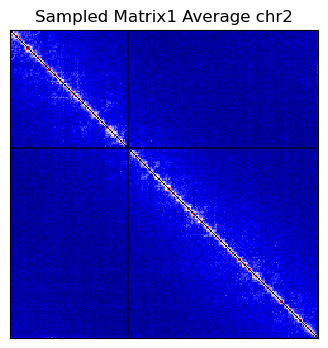

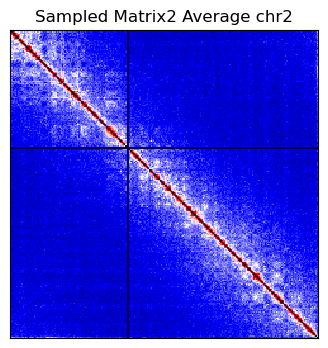

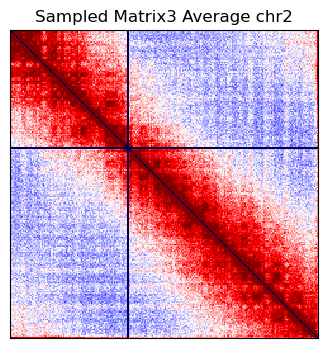

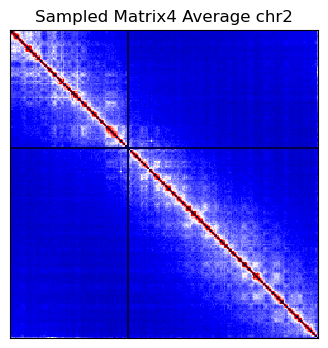

In [41]:
cmap = "seismic"
plot_matrix(mean_sample_mat1_cell,f"Sampled Matrix1 Average chr2",cmap,vmax=0.08,show=False)
plot_matrix(mean_sample_mat2_cell,f"Sampled Matrix2 Average chr2",cmap,vmax=0.1,show=False)
plot_matrix(mean_sample_mat3_cell,f"Sampled Matrix3 Average chr2",cmap,vmax=0.1,show=False)
plot_matrix(mean_sample_mat4_cell,f"Sampled Matrix4 Average chr2",cmap,vmax=0.5,show=False)